In [2]:
%who

PmEQ_drght_wNan	 PmEQ_drght_wNan_alltimescale	 awra_dir	 calc_PmEQ_from_delSM	 da_sm	 da_sm_diff	 da_sm_drght1	 da_sm_drght2	 da_sm_end	 
da_sm_perc_end	 data_path	 dayofyear	 drght_file1	 drght_file2	 ds_doy	 ds_reg	 ds_sm	 ds_sm_drght1	 
ds_sm_drght2	 ds_sm_perc	 ds_temp	 file_names	 fname_reg	 lat_new	 lat_slice	 lon_new	 lon_slice	 
np	 outdir	 params	 pd	 perc_drought_end	 plt	 projdir	 rsq	 slope	 
sm_diff	 sm_diff_drght	 sm_diff_drght_wNan	 time_slice	 ts	 ts_list	 xr	 


### Converting delta SM to P-E-Q for the Millennium drought and the Recent drought

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

awra_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/'
file_names = 'sm_[1-2]*.nc'

# get the sm values corresponding to the drought period
ds_temp = xr.open_mfdataset(awra_dir + file_names, chunks = {'lat':400,'lon':400})
# converting the datatypes of SM to match P
lat_new = np.float32(ds_temp['latitude'])
lon_new = np.float32(ds_temp['longitude'])

# get the amount of sm required to end the drought from the reference percentile file
perc_drought_end = 0.3
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
dayofyear = np.arange(366) + 1
da_sm_perc_end = ds_sm_perc['sm'].sel(quantile = perc_drought_end).assign_coords(dayofyear = dayofyear)

lat_slice = slice(-32, -39)
lon_slice = slice(139, 152)
time_slice = [slice('2000-01-01', '2010-12-31'), slice('2017-01-01', '2020-05-31')] #slice('1911-01-02','2020-03-29')

sm_diff = []
for ts in time_slice:
    ds_sm = ds_temp.rename({'latitude':'lat','longitude':'lon'}).assign_coords(lat = lat_new, lon = lon_new).sel(lat = lat_slice, lon = lon_slice, time = ts)
    ds_doy = np.array(ds_sm['time.dayofyear'])   # day of the year in ds, the sm dataset
    # soil moisture data array with 'dayofyear' as the co-ordinate variable
    da_sm = ds_sm['sm'].reset_index('time').rename({'time':'dayofyear', 'time_':'time'}).assign_coords({'dayofyear': ds_doy})

    # the sm required to reach the drought ending threshold
    da_sm_end = da_sm_perc_end.sel(dayofyear = ds_doy)
    da_sm_diff = (da_sm_end - da_sm).reset_index('dayofyear').rename({'dayofyear':'time','dayofyear_':'dayofyear'})
    sm_diff.append(da_sm_diff)
    
 # get the data indicating drought grids (1 = drought)
drght_file1 = 'sm_drought_200001_to_201012.nc'
drght_file2 = 'sm_drought_201701_to_202005.nc'

# get the location of grid points in drought
ds_sm_drght1 = xr.open_dataset(projdir + 'sm_refPeriod_perc/' + drght_file1)
da_sm_drght1 = ds_sm_drght1['sm_drought']
ds_sm_drght2 = xr.open_dataset(projdir + 'sm_refPeriod_perc/' + drght_file2)
da_sm_drght2 = ds_sm_drght2['sm_drought']

# get the soil mosisture deficit at only the drought grids
sm_diff_drght = []
sm_diff_drght.append(sm_diff[0]*da_sm_drght1)
sm_diff_drght.append(sm_diff[1]*da_sm_drght2)

sm_diff_drght_wNan = [x.where(x > 0) for x in sm_diff_drght]

# select time scales at which we want this drought to break
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'

def calc_PmEQ_from_delSM(delSM, slope, intercept = 0):
    PmEQ_temp = (delSM - intercept)/slope
    PmEQ = PmEQ_temp.where(PmEQ_temp > 0)
    return(PmEQ)

ts_list = [2, 6, 12]

PmEQ_drght_wNan_alltimescale = []
for ts in ts_list:
    # get the regression relationship between soil moisture and P-E-Q
    data_path = projdir + 'sm_week' + str(ts) + '/'
    fname_reg = 'sm_PmEQ_lm_noIntercept_results.nc'
    ds_reg = xr.open_dataset(data_path + fname_reg)

    # names of data arrays within the file
    params = 'lm_params'
    rsq = 'r-squared'

    # get the intercept, coefficient and r-squared of SM = Intercept + coefficient*(P-E-Q)
    # intercept = ds_reg[params].sel(parameter = "Intercept")
    slope = ds_reg[params].sel(parameter = "PmEQ")
    rsq = ds_reg[rsq]

    # get the PmEQ at different timescales
    PmEQ_drght_wNan = [calc_PmEQ_from_delSM(x, slope) for x in sm_diff_drght_wNan]
    
    # How different is P-E-Q from SM deficit for both the droughts? - commented as I've already plotted this
    # for i in range(2):
    #     diff_PmEQ_sm = PmEQ_drght_wNan[i] - sm_diff_drght_wNan[i]
    #     diff_PmEQ_sm.mean('time').plot()
    #     plt.savefig(outdir + 'drought' + str(i) + '_PmEQ_minus_delSM_mean_week' + str(ts) + '_noIntercept.png')
    #     plt.clf()
    
    PmEQ_drght_wNan_alltimescale.append(PmEQ_drght_wNan)

In [7]:
drght_name = ['millennium', 'recent']
for i in range(2):
    PmEQ_drghtX = xr.concat([PmEQ_drght_wNan_alltimescale[0][i], PmEQ_drght_wNan_alltimescale[1][i], PmEQ_drght_wNan_alltimescale[2][i]], dim = "timescale").assign_coords({'timescale':ts_list})
    out_file = projdir + 'sm_refPeriod_perc/' + drght_name[i] + 'drght_PmEQ_various_timescales.nc'
    PmEQ_drghtX.to_netcdf(out_file)

### Converting sm deficit to P-E-Q for drought events identified using the full period of record

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
out_dir = projdir + 'sm_droughts/'
prefix_PmEQ = 'PmEQ_events'
prefix_sm = 'sm_events'

awra_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/'
file_names = 'sm_[1-2]*.nc'

lat_slice = slice(-32, -39)
lon_slice = slice(139, 152)

# select time scales at which we want this drought to break
ts_list = [2, 6, 12]

# get the full sm dataset
ds_temp = xr.open_mfdataset(awra_dir + file_names, chunks = {'lat':400,'lon':400})
# converting the datatypes of SM to match P
lat_new = np.float32(ds_temp['latitude'])
lon_new = np.float32(ds_temp['longitude'])

# get the threshold of sm required to end the drought from the reference percentile file
perc_drought_end = 0.3
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
dayofyear = np.arange(366) + 1
da_sm_perc_end = ds_sm_perc['sm'].sel(quantile = perc_drought_end).assign_coords(dayofyear = dayofyear)

def create_filepath(ds, prefix='filename', root_path="."):
    """
    Generate a filepath when given an xarray dataset or dataarray
    """
    start = ds.time[0].dt.strftime("%Y-%m").data
    end = ds.time[-1].dt.strftime("%Y-%m").data
    filepath = f'{root_path}/{prefix}_{start}_{end}.nc'
    return filepath

def calc_PmEQ_from_delSM(delSM, slope, intercept = 0):
    PmEQ_temp = (delSM - intercept)/slope
    PmEQ = PmEQ_temp.where(PmEQ_temp > 0)
    return(PmEQ)

startyr_list = list(range(1911, 2020, 10))

for styr in startyr_list:
    # get the data indicating drought grids (1 = drought)
    drght_files = 'events_' + str(styr) + '*.nc'
    ds_sm_drght = xr.open_mfdataset(out_dir + drght_files)
    
    # subset the sm data for the same time period as the events
    enyr = ds_sm_drght['time.year'].values[-1]
    time_slice = slice(str(styr) + '-01-01', str(enyr) + '-12-31')
    ds_sm = ds_temp.rename({'latitude':'lat','longitude':'lon'}).assign_coords(lat = lat_new, lon = lon_new).sel(lat = lat_slice, lon = lon_slice, time = time_slice)
    ds_doy = np.array(ds_sm['time.dayofyear'])   # day of the year in ds, the sm dataset
    # soil moisture data array with 'dayofyear' as the co-ordinate variable
    da_sm = ds_sm['sm'].reset_index('time').rename({'time':'dayofyear', 'time_':'time'}).assign_coords({'dayofyear': ds_doy})

    # the sm required to reach the drought ending threshold
    da_sm_end = da_sm_perc_end.sel(dayofyear = ds_doy)
    da_sm_diff = (da_sm_end - da_sm).reset_index('dayofyear').rename({'dayofyear':'time','dayofyear_':'dayofyear'})

    # get the soil mosisture deficit at only the drought grids
    da_sm_diff_drght = da_sm_diff * ds_sm_drght['sm_drought']
    da_sm_diff_drght_wNan = da_sm_diff_drght.where(da_sm_diff_drght > 0).rename('sm_deficit')

    # get corresponding P-E-Q at various timescales from the sm_diff vs. P-E-Q relationship
    PmEQ_drght_wNan_alltimescale = []
    
    for ts in ts_list:
        # get the regression fit results
        data_path = projdir + 'sm_week' + str(ts) + '/'
        fname_reg = 'sm_PmEQ_lm_noIntercept_results.nc'
        ds_reg = xr.open_dataset(data_path + fname_reg)

        # get the coefficient of P-E-Q
        slope = ds_reg['lm_params'].sel(parameter = "PmEQ")

        # get the PmEQ at different timescales
        da_PmEQ_drght_wNan = calc_PmEQ_from_delSM(da_sm_diff_drght_wNan, slope)
        PmEQ_drght_wNan_alltimescale.append(da_PmEQ_drght_wNan)

        # How different is P-E-Q from SM deficit for both the droughts? - commented as I'll plot this later from the saved files
        # da_diff_PmEQ_sm = da_PmEQ_drght_wNan - da_sm_diff_drght_wNan
        # da_diff_PmEQ_sm.mean('time').plot()
        # plt.savefig(outdir + 'drought' + str(i) + '_PmEQ_minus_delSM_mean_week' + str(ts) + '_noIntercept.png')
        # plt.clf()
    
    da_PmEQ_drght = xr.concat(PmEQ_drght_wNan_alltimescale, dim = "timescale").assign_coords({'timescale':ts_list}).rename('PminusEQ').chunk({'timescale':len(ts_list)})
        
    out_file_PmEQ = create_filepath(da_PmEQ_drght, prefix = prefix_PmEQ, root_path = out_dir)
    out_file_sm = create_filepath(da_sm_diff_drght_wNan, prefix = prefix_sm, root_path = out_dir)
    
    da_PmEQ_drght.to_netcdf(out_file_PmEQ)
    da_sm_diff_drght_wNan.to_netcdf(out_file_sm)

In [4]:
da_PmEQ_drght = xr.concat(PmEQ_drght_wNan_alltimescale, dim = "timescale").assign_coords({'timescale':ts_list}).rename('PminusEQ').chunk({'timescale':len(ts_list)})
da_PmEQ_drght

<xarray.DataArray 'PminusEQ' (timescale: 3, time: 3653, lat: 141, lon: 261)>
dask.array<rechunk-merge, shape=(3, 3653, 141, 261), dtype=float64, chunksize=(3, 366, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
  * time       (time) datetime64[ns] 1911-01-01 1911-01-02 ... 1920-12-31
    dayofyear  (time) int64 dask.array<chunksize=(3653,), meta=np.ndarray>
    parameter  <U4 'PmEQ'
  * timescale  (timescale) int64 2 6 12

In [5]:
da_sm_diff_drght_wNan

<xarray.DataArray (time: 3653, lat: 141, lon: 261)>
dask.array<where, shape=(3653, 141, 261), dtype=float64, chunksize=(366, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
  * time       (time) datetime64[ns] 1911-01-01 1911-01-02 ... 1920-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366

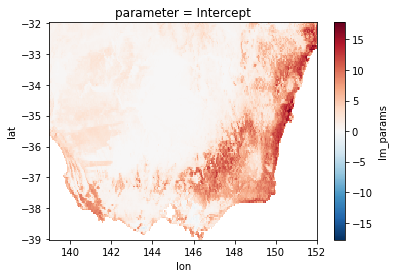

In [36]:
intercept.plot()

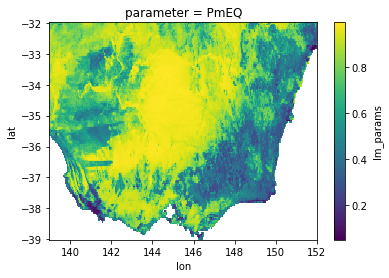

In [11]:
slope.plot()

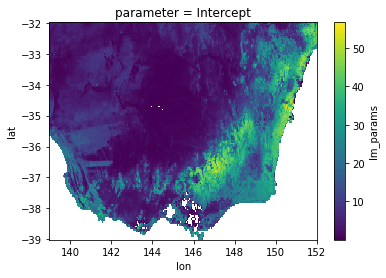

In [17]:
intercept.where(intercept>0).plot()

In [11]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
prefix = ['millennium', 'recent']
for j in range(len(ts_list)):
    for i in range(2):
        temp = PmEQ_drght_wNan_alltimescale[j][i].mean('time').plot()
        #temp.where(temp>0).plot()
        plt.savefig(outdir + prefix[i] + '_drought_PmEQ_week' + str(ts_list[j]) + '.png')
        plt.clf()
    

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
prefix = ['millennium', 'recent']
lat_size = -32-(-39)
lon_size = 152-139
aspect = lon_size/lat_size
for i in [1]:
    PmEQ_for_plot = []
    for j in range(len(ts_list)):
        temp = PmEQ_drght_wNan_alltimescale[j][i].mean('time')
        PmEQ_for_plot.append(temp)
    xr_for_plt = xr.concat(PmEQ_for_plot, dim="timescale").assign_coords({'timescale':ts_list})
    xr_for_plt.plot(x = "lon", y = "lat", col = "timescale", col_wrap=3, aspect=aspect, cmap="Reds")
    plt.savefig(outdir + prefix[i] + '_drought_PmEQ_week_alltimescale.png')
    plt.clf()
    
    # for i in range(2):
    #     temp = PmEQ_drght_wNan_alltimescale[j][i].mean('time').plot()
    #     #temp.where(temp>0).plot()
    #     plt.savefig(outdir + prefix[i] + '_drought_PmEQ_week' + str(ts_list[j]) + '.png')
    #     plt.clf()

<Figure size 1275.43x216 with 0 Axes>

In [15]:
sm_diff_drght_wNan_timescale

NameError: name 'sm_diff_drght_wNan_timescale' is not defined

In [20]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
prefix = ['millennium', 'recent']
lat_size = -32-(-39)
lon_size = 152-139
aspect = lon_size/lat_size
for i in range(2):
    temp = sm_diff_drght_wNan[i].mean('time')
    temp.where(temp>0).plot(cmap="Reds", aspect=aspect, size=3)
    plt.savefig(outdir + prefix[i] + '_drought_sm_diff_timemean.png')
    plt.clf()

<Figure size 401.143x216 with 0 Axes>

<Figure size 401.143x216 with 0 Axes>

In [ ]:
diff_PmEQ_sm.mean('time').plot()

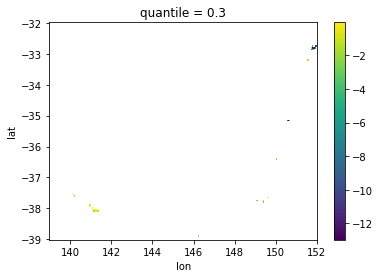

In [32]:
PmEQ_mean = PmEQ_drght_wNan[0].mean('time')
PmEQ_mean.where(PmEQ_mean < 0).plot()

In [ ]:
sm_diff_drght_wNan[0].mean('time').plot()

In [ ]:
P_mean = PmEQ_drght_wNan[0].mean('time')
PmEQ_mean.where(PmEQ_mean < 0).plot()

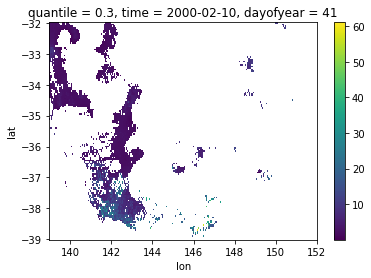

In [15]:
sm_diff_drght[0].where(sm_diff_drght[0] > 0)[40,:,:].plot()

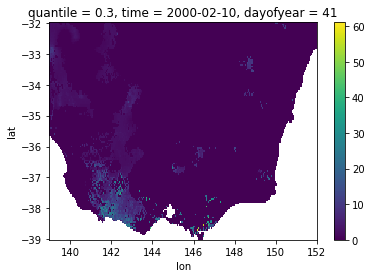

In [16]:
sm_diff_drght[0][40,:,:].plot()

In [8]:
sm_diff_drght[0]

<xarray.DataArray (time: 4018, lat: 141, lon: 261)>
dask.array<mul, shape=(4018, 141, 261), dtype=float64, chunksize=(366, 141, 261), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
    quantile   float64 0.3
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

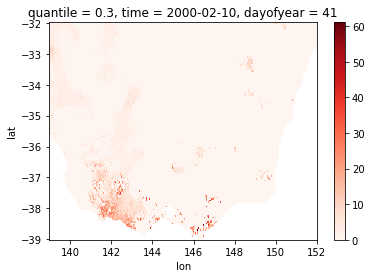

In [19]:
sm_diff_drght[0][40,:,:].plot(cmap="Reds")

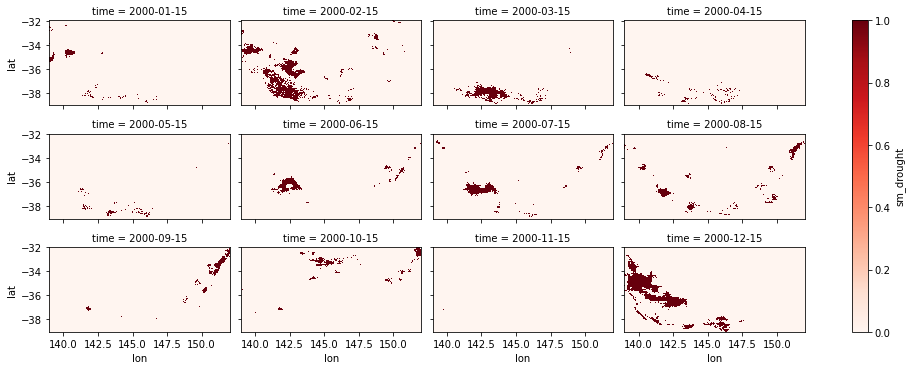

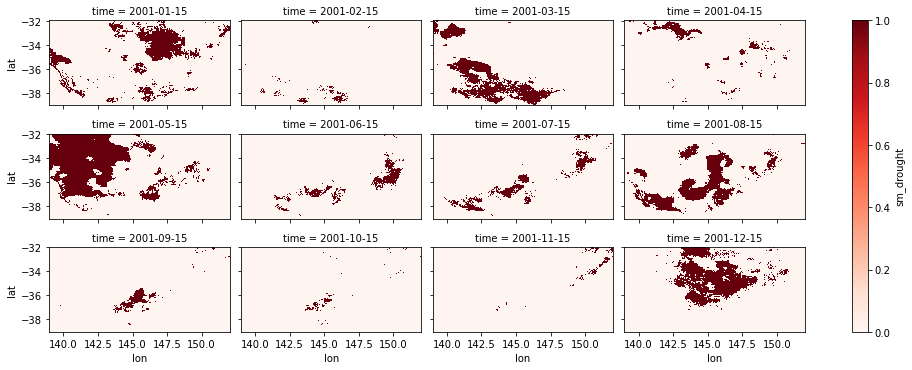

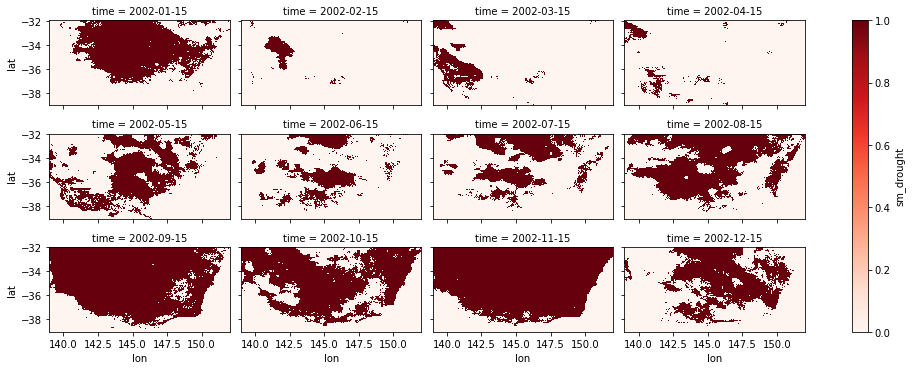

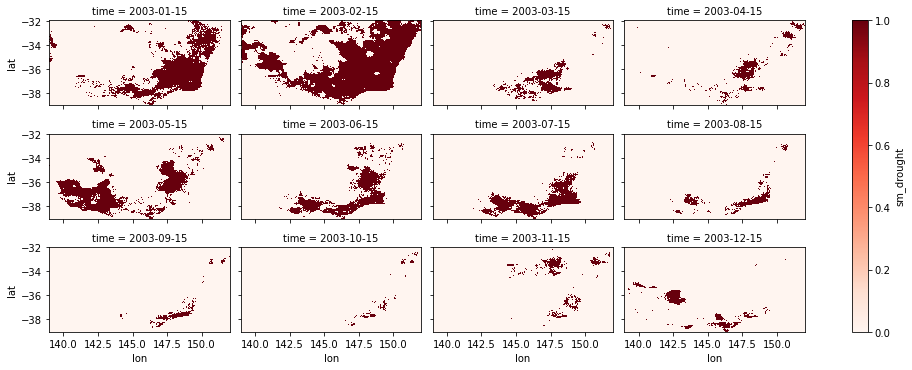

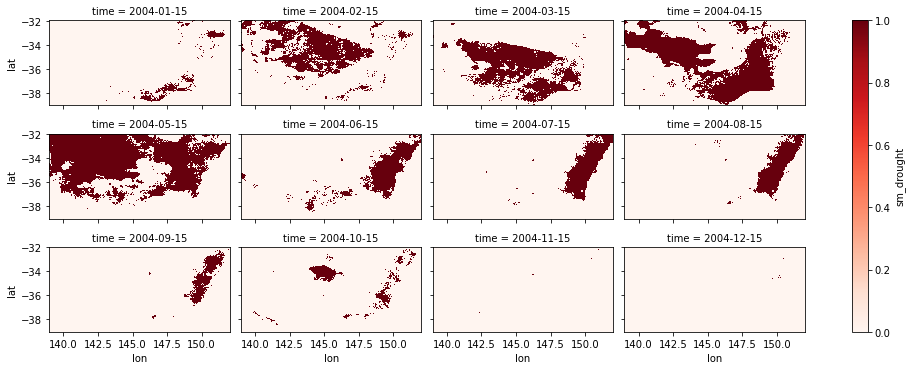

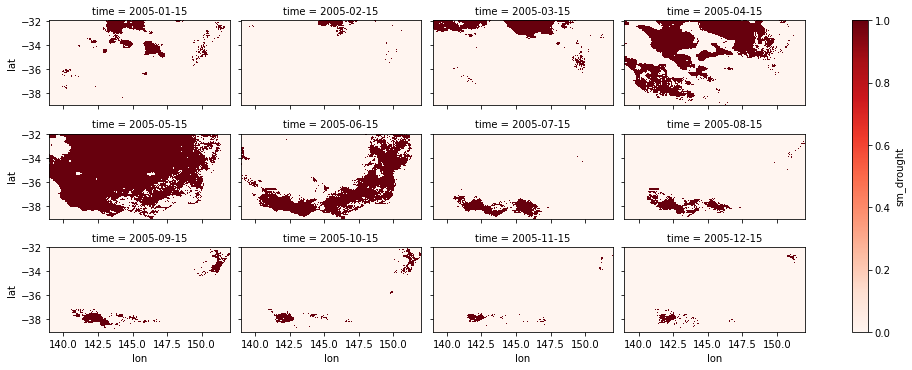

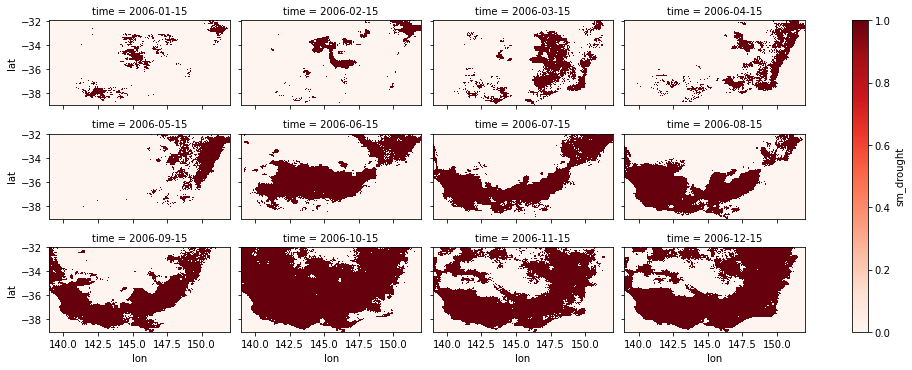

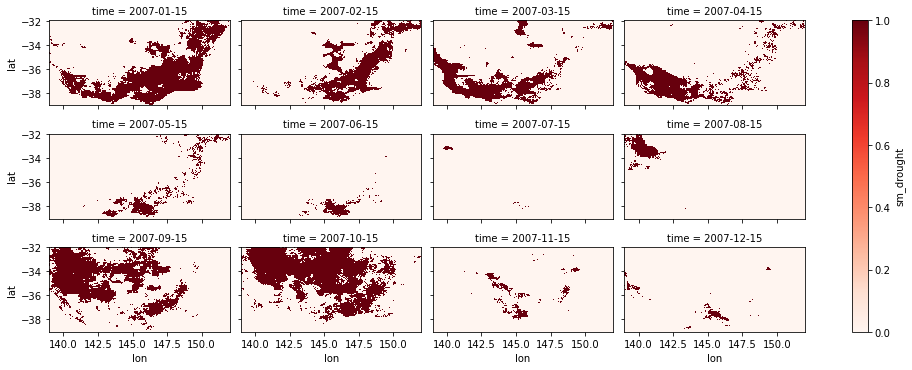

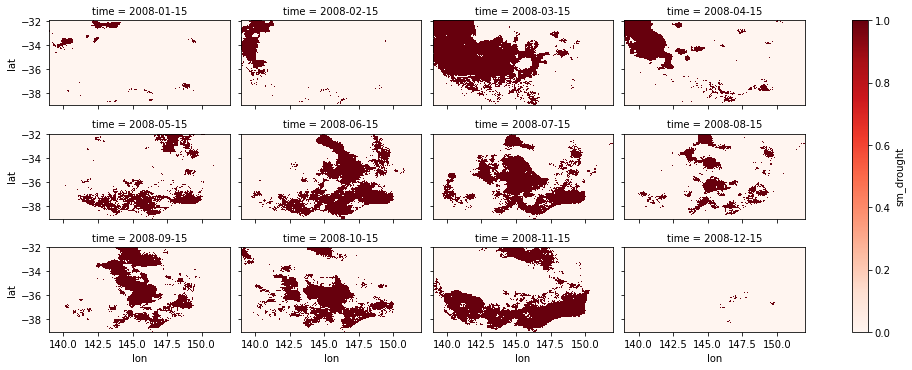

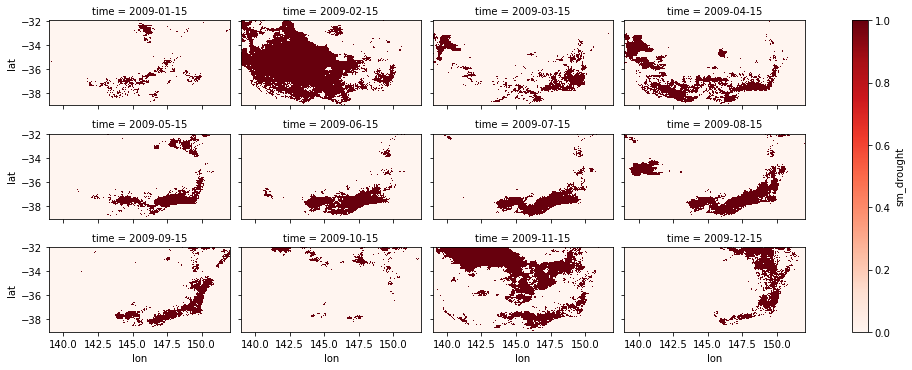

In [29]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'

for yr_sel in [str(x) for x in range(2000, 2010)]:
    # yr_sel2 = '2018'
    d_sel = '15'
    figname = 'millennium_drought_' + yr_sel + '_day' + d_sel + '.png'
    # figname = 'recent_drought_' + yr_sel + '_' + yr_sel2 + '_day' + d_sel + '.png'
    time_sel = [yr_sel + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-', '-05-', '-06-', \
                '-07-', '-08-', '-09-', '-10-', '-11-', '-12-']]
    # time_sel.extend([yr_sel2 + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-']])

    lat_size = -32-(-39)
    lon_size = 152-139
    aspect = lon_size/lat_size
    da_sm_drght1.sel(time = time_sel).plot(x = "lon", y = "lat", col = "time", col_wrap = 4, cmap = "Reds", aspect = aspect, size = 1.75)
    plt.savefig(outdir + figname)

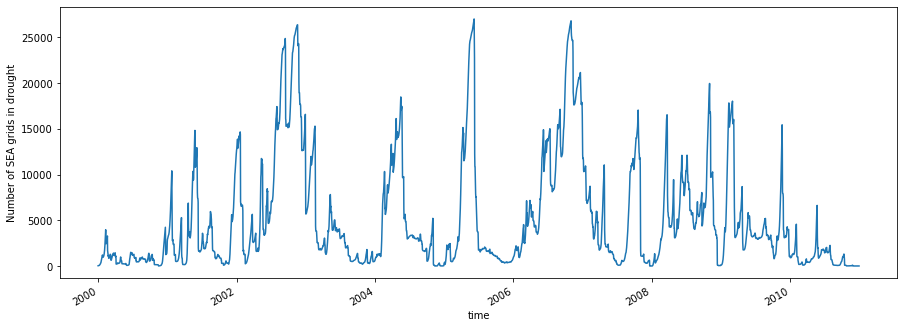

In [6]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
da_sm_drght1.sum(['lat', 'lon']).rename('Number of SEA grids in drought').plot(size=5, aspect=3)
plt.savefig(outdir + 'millennium_drought_no_of_grids_indrought.png')

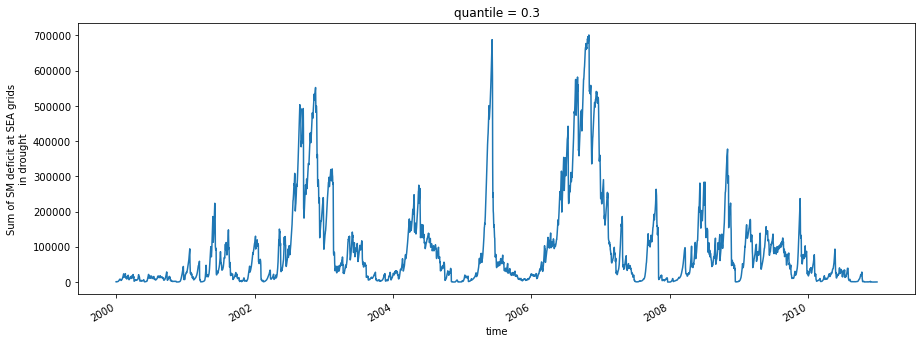

In [10]:
sm_diff_drght[0].sum(['lat', 'lon']).rename('Sum of SM deficit at SEA grids in drought').plot(size=5, aspect=3)
plt.savefig(outdir + 'millennium_drought_sum_sm_diff_grids_indrought.png')

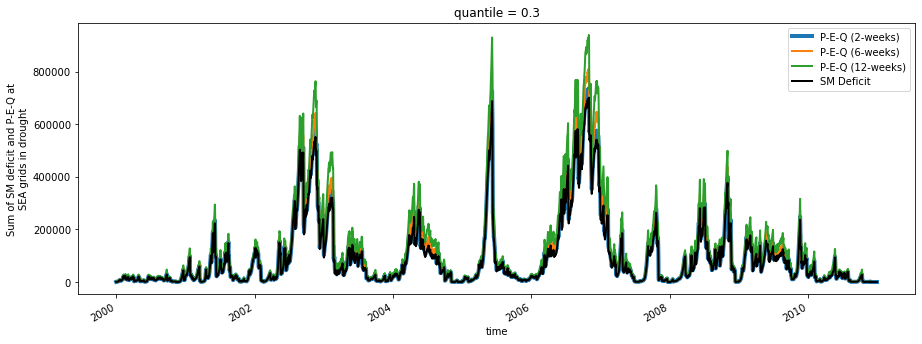

In [6]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
PmEQ_drght_wNan_alltimescale[0][0].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(size=5, aspect=3, label = 'P-E-Q (2-weeks)', linewidth=4) #, linewidth=2, label='P-E-Q')
PmEQ_drght_wNan_alltimescale[1][0].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'P-E-Q (6-weeks)', linewidth=2)
PmEQ_drght_wNan_alltimescale[2][0].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'P-E-Q (12-weeks)', linewidth=2)
sm_diff_drght[0].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'SM Deficit', linewidth=2,color="black") #size=5, aspect=3) #, label = 'SM Deficit')
plt.legend()
plt.savefig(outdir + 'millennium_drought_moisture_accum_noI_to_break_drought_diffTs.png')

In [5]:
PmEQ_drght_wNan_alltimescale

[[<xarray.DataArray (time: 4018, lat: 141, lon: 261)>
  dask.array<where, shape=(4018, 141, 261), dtype=float64, chunksize=(366, 141, 261), chunktype=numpy.ndarray>
  Coordinates:
    * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
    * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
      quantile   float64 0.3
    * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31
      dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365,
  <xarray.DataArray (time: 1247, lat: 141, lon: 261)>
  dask.array<where, shape=(1247, 141, 261), dtype=float64, chunksize=(365, 141, 261), chunktype=numpy.ndarray>
  Coordinates:
    * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
    * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
      quantile   float64 0.3
    * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-05-31
      dayofyear  (tim

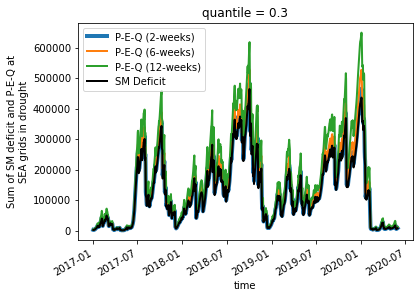

In [7]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'
PmEQ_drght_wNan_alltimescale[0][1].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'P-E-Q (2-weeks)', linewidth=4) #, linewidth=2, label='P-E-Q')
PmEQ_drght_wNan_alltimescale[1][1].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'P-E-Q (6-weeks)', linewidth=2)
PmEQ_drght_wNan_alltimescale[2][1].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'P-E-Q (12-weeks)', linewidth=2)
sm_diff_drght[1].sum(['lat', 'lon']).rename('Sum of SM deficit and P-E-Q at SEA grids in drought').plot(label = 'SM Deficit', linewidth=2,color="black") #size=5, aspect=3) #, label = 'SM Deficit')
plt.legend()
plt.savefig(outdir + 'recent_drought_moisture_accum_noI_to_break_drought_diffTs.png')

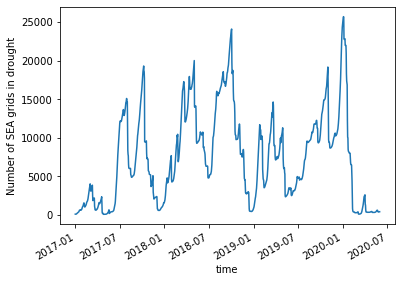

In [36]:
da_sm_drght2.sum(['lat', 'lon']).rename('Number of SEA grids in drought').plot()
plt.savefig(outdir + 'recent_drought_no_of_grids_indrought.png')

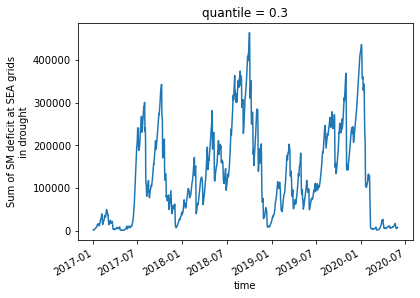

In [11]:
sm_diff_drght[1].sum(['lat', 'lon']).rename('Sum of SM deficit at SEA grids in drought').plot()
plt.savefig(outdir + 'recent_drought_sum_sm_diff_grids_indrought.png')

In [ ]:
da_sm_drght2.groupby('time.month').mean('time')

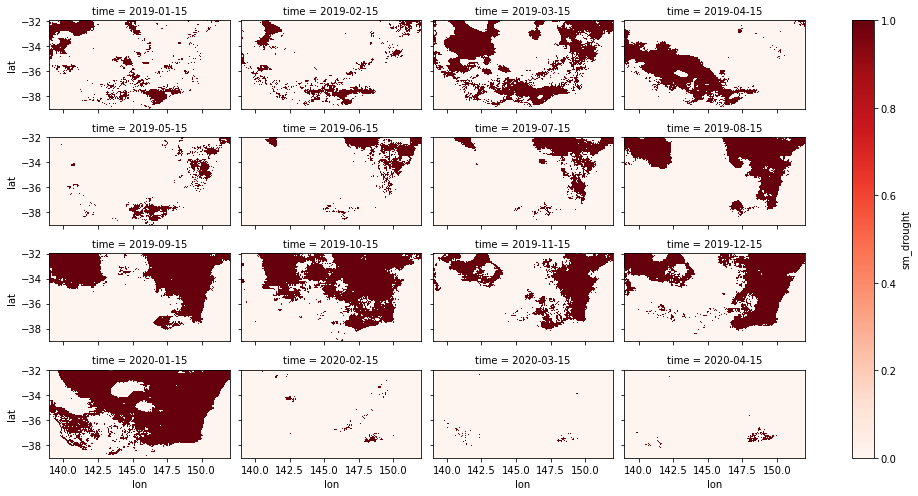

In [25]:
import matplotlib.pyplot as plt
outdir = 'figures/drought_events/'

yr_sel = '2019'
yr_sel2 = '2020'
d_sel = '15'
# figname = 'recent_drought_' + yr_sel + '_day' + d_sel + '.png'
figname = 'recent_drought_' + yr_sel + '_' + yr_sel2 + '_day' + d_sel + '.png'
time_sel = [yr_sel + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-', '-05-', '-06-', \
            '-07-', '-08-', '-09-', '-10-', '-11-', '-12-']]
time_sel.extend([yr_sel2 + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-']])

lat_size = -32-(-39)
lon_size = 152-139
aspect = lon_size/lat_size
da_sm_drght2.sel(time = time_sel).plot(x = "lon", y = "lat", col = "time", col_wrap = 4, cmap = "Reds", aspect = aspect, size = 1.75)
plt.savefig(outdir + figname)

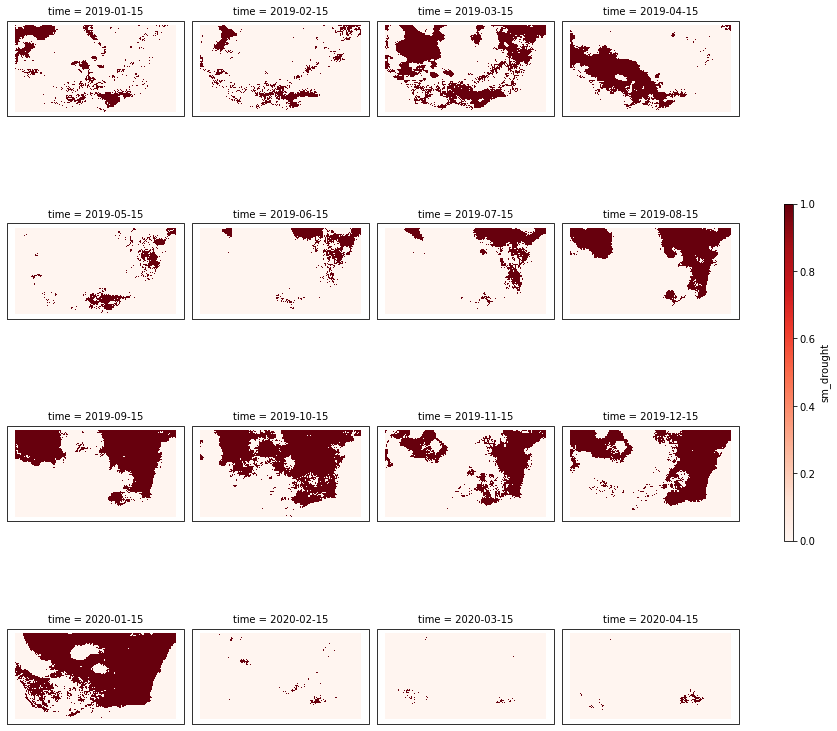

In [13]:
import cartopy.crs as ccrs

yr_sel = '2019'
yr_sel2 = '2020'
d_sel = '15'
# figname = 'recent_drought_' + yr_sel + '_day' + d_sel + '.png'
figname = 'recent_drought_' + yr_sel + '_' + yr_sel2 + '_day' + d_sel + '.png'
time_sel = [yr_sel + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-', '-05-', '-06-', \
            '-07-', '-08-', '-09-', '-10-', '-11-', '-12-']]
time_sel.extend([yr_sel2 + m + d_sel for m in ['-01-', '-02-', '-03-', '-04-']])

fg = da_sm_drght2.sel(time = time_sel).plot(x = 'lon', y = 'lat', col = 'time', col_wrap =4, cmap = "Reds", \
                                                     subplot_kws={ "projection": ccrs.LambertConformal()}, \
                                                     cbar_kwargs={"orientation": "vertical", "shrink": 0.4, "aspect": 40}, robust=True)
    
[ax.coastlines() for ax in fg.axes.flatten()]


In [7]:
da_sm_drght1

<xarray.DataArray 'sm_drought' (lat: 141, lon: 261, time: 4018)>
[147866418 values with dtype=int64]
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31
    dayofyear  (time) int64 ...

In [1]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8551      main dask-wor   ad9701  R       0:52      1 ood-n6
              8520       vdi sys/dash   ad9701  R    2:56:19      1 ood-vn27
              8537       vdi sys/dash   ad9701  R    1:35:59      1 ood-vn27
